In the previous notebook, we explored the basics of the `bcs` package which eventually, `retrotide` will call upon to build a chimeric PKS given a target molecule. Given that PKSs can be slightly complicated and are a little different from regular, monofunctional enzymes, however, in this notebook, we will develop and implement atom mappings that can help us visualize the different functional group transformations that occur within a given module.

In [10]:
from retrotide import retrotide, structureDB

In [11]:
import bcs

In [12]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, Draw
from typing import List

Let's begin by building a simple PKS comprising just one extension module beyond the initial loading module

In [13]:
loading_AT_domain = bcs.AT(active = True, substrate = "Acetyl-CoA")
loading_module = bcs.Module(domains = {bcs.AT: loading_AT_domain}, loading = True)

AT_domain_mod1 = bcs.AT(active = True, substrate = "Malonyl-CoA")
module1 = bcs.Module(domains = {bcs.AT: AT_domain_mod1}, loading = False)

cluster = bcs.Cluster(modules = [loading_module, module1])

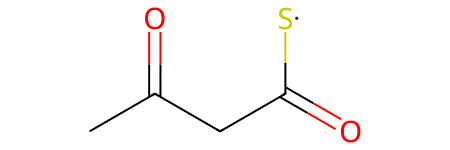

In [14]:
cluster.computeProduct(structureDB)

In [15]:
modules_list = cluster.modules
modules_list

[["AT{'substrate': 'Acetyl-CoA'}", 'loading: True'],
 ["AT{'substrate': 'Malonyl-CoA'}", 'loading: False']]

Here, we write a function that can generate PKS atom mappings by labelling which atoms are being transformed by which modules in particular.

In [7]:
def generate_PKS_atom_map(cluster: bcs.Cluster) -> List[Chem.rdchem.Mol]:

    modules_list = cluster.modules
    
    atom_labels_list = [f"LM" if i==0 else f"M{i}" for i in range(len(modules_list))]
    labelled_mols_list = []
    
    for module_num in range(0, len(modules_list)):
    
        # for the loading module specifically
        if module_num == 0:
    
            # start rebuilding the input chimeric PKS 
            cluster = bcs.Cluster(modules = [ modules_list[0] ])
            current_product_mol = cluster.computeProduct(structureDB)
            current_label = atom_labels_list[0]
    
            # label atoms installed by the loading module ("LM")
            for i, atom in enumerate(current_product_mol.GetAtoms()):
                atom.SetProp("atomLabel", current_label)
    
            labelled_mols_list.append(current_product_mol)
    
        # for 
        else:
    
            # for any downstream extension module, extract atom label (module number, e.g. M1)
            current_label = atom_labels_list[module_num]
    
            # compute the product structure up until this current module
            modules_sublist = modules_list[0: (module_num + 1)]
            cluster = bcs.Cluster(modules = modules_sublist)
            current_product_mol = cluster.computeProduct(structureDB)
            
            # extract a sublist of the previous produts and labels up until this current module
            previous_products_sublist = labelled_mols_list[0: module_num]
            previous_labels_sublist = atom_labels_list[0: module_num]
    
            # then, iteratively find the MCS with each previous product and apply labels starting from the loading module
            for i in range(0, len(previous_products_sublist)):
    
                previous_product_mol = previous_products_sublist[i]
                previous_label = previous_labels_sublist[i]
    
                substruct_result = rdFMCS.FindMCS([previous_product_mol, current_product_mol],
                                                   timeout = 1,
                                                   matchValences = True,
                                                   matchChiralTag = False,
                                                   bondCompare = Chem.rdFMCS.BondCompare.CompareOrderExact)
    
                match = current_product_mol.GetSubstructMatches(substruct_result.queryMol)
    
                if match:
                    for idx, atom_idx in enumerate(match[0]):
                        previous_atom = previous_product_mol.GetAtomWithIdx(idx)
    
                        # check first if a label exists on this atom
                        # if a label does exist from the previous module, let it be
                        try:
                            current_product_mol.GetAtomWithIdx(atom_idx).GetProp('atomLabel')
    
                        # if a label does not exist, then label with this current module
                        except KeyError:
                            current_product_mol.GetAtomWithIdx(atom_idx).SetProp('atomLabel', previous_label)
            
            # after labelling all previous atoms with previous structures, label atoms added in this current module
            for atom in current_product_mol.GetAtoms():
                try:
                    atom.GetProp('atomLabel')
                except:
                    atom.SetProp('atomLabel', current_label)
    
            labelled_mols_list.append(current_product_mol)
    
    return labelled_mols_list

In [16]:
labelled_mols_list = generate_PKS_atom_map(cluster)

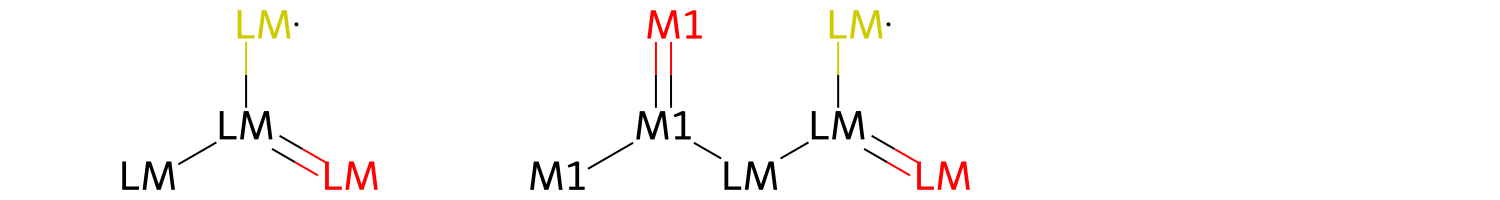

In [17]:
Draw.MolsToGridImage(mols = labelled_mols_list,
                     molsPerRow = 3,
                     subImgSize = (500, 200))

#### More examples of visualizing PKS atom mappings

In [38]:
loading_AT_domain = bcs.AT(active = True, substrate = "Methylmalonyl-CoA")
loading_module = bcs.Module(domains = {bcs.AT: loading_AT_domain}, loading = True)

AT_domain_mod1 = bcs.AT(active = True, substrate = "Methylmalonyl-CoA")
KR_domain_mod1 = bcs.KR(active = True, type = "B1")
DH_domain_mod1 = bcs.DH(active = True)
ER_domain_mod1 = bcs.ER(active = True)

module1 = bcs.Module(domains = {bcs.AT: AT_domain_mod1,
                                bcs.KR: KR_domain_mod1,
                                bcs.DH: DH_domain_mod1,
                                bcs.ER: ER_domain_mod1}, 
                     loading = False)

AT_domain_mod2 = bcs.AT(active = True, substrate = "Methylmalonyl-CoA")
KR_domain_mod2 = bcs.KR(active = True, type = "B1")
DH_domain_mod2 = bcs.DH(active = True)
ER_domain_mod2 = bcs.ER(active = True)
module2 = bcs.Module(domains = {bcs.AT: AT_domain_mod2,
                                bcs.KR: KR_domain_mod2,
                                bcs.DH: DH_domain_mod2,
                                bcs.ER: ER_domain_mod2}, loading = False)

cluster = bcs.Cluster(modules = [loading_module, module1, module2])

In [39]:
labelled_mols_list = generate_PKS_atom_map(cluster)

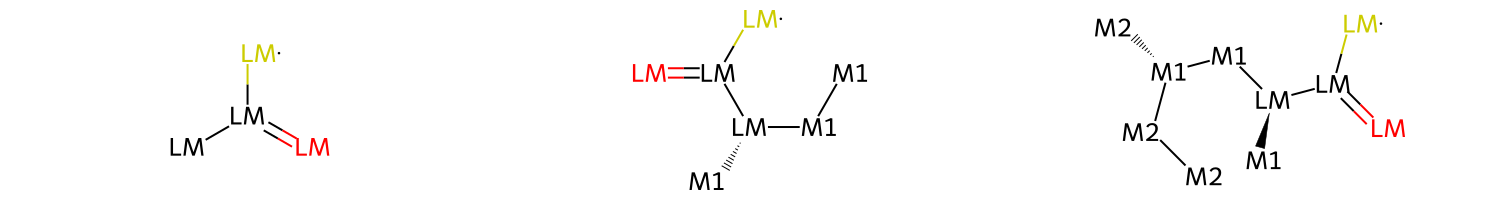

In [40]:
Draw.MolsToGridImage(mols = labelled_mols_list,
                     molsPerRow = 3,
                     subImgSize = (500, 200))